In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

pd.set_option('display.precision', 2)
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Tutorial on human data

### Read in data

In [4]:
seqs = polygraph.input.read_seqs('human_seqs.txt', sep=",")
seqs.head(3)

,SeqID,Sequence,Group
0,seq_0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp
1,seq_1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp
2,seq_2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp


In [5]:
print(seqs.Group.value_counts())

Group
FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: count, dtype: int64


# 1. Sequence composition

## 1.1 GC Content

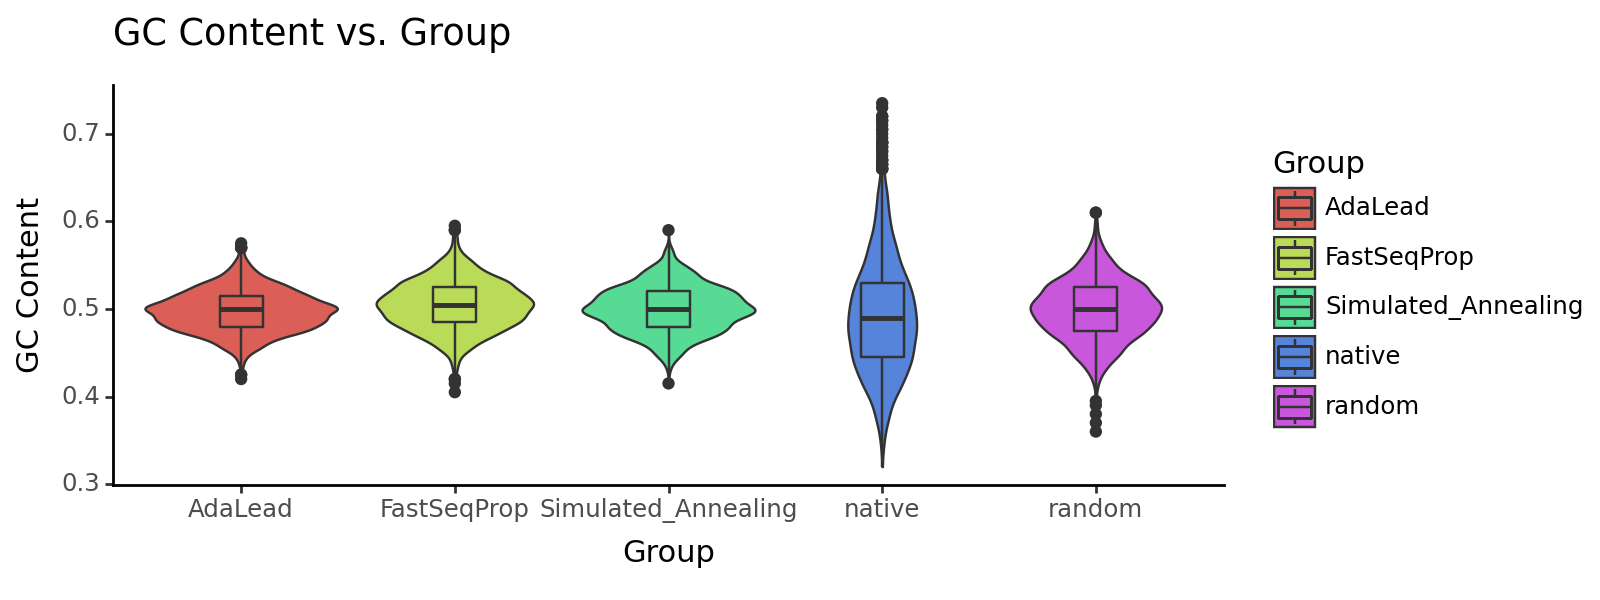

<Figure Size: (800 x 300)>

In [6]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(8, 3))

In [7]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.00e+00     1.34e-10             8.48e-02  7.99e-06   
 FastSeqProp          1.34e-10     1.00e+00             3.60e-04  1.28e-30   
 Simulated_Annealing  8.48e-02     3.60e-04             1.00e+00  3.79e-13   
 native               7.99e-06     1.28e-30             3.79e-13  1.00e+00   
 random               1.00e+00     1.06e-06             1.00e+00  1.73e-09   
 
                        random  
 AdaLead              1.00e+00  
 FastSeqProp          1.06e-06  
 Simulated_Annealing  1.00e+00  
 native               1.73e-09  
 random               1.00e+00  }

## 1.2 Length distribution

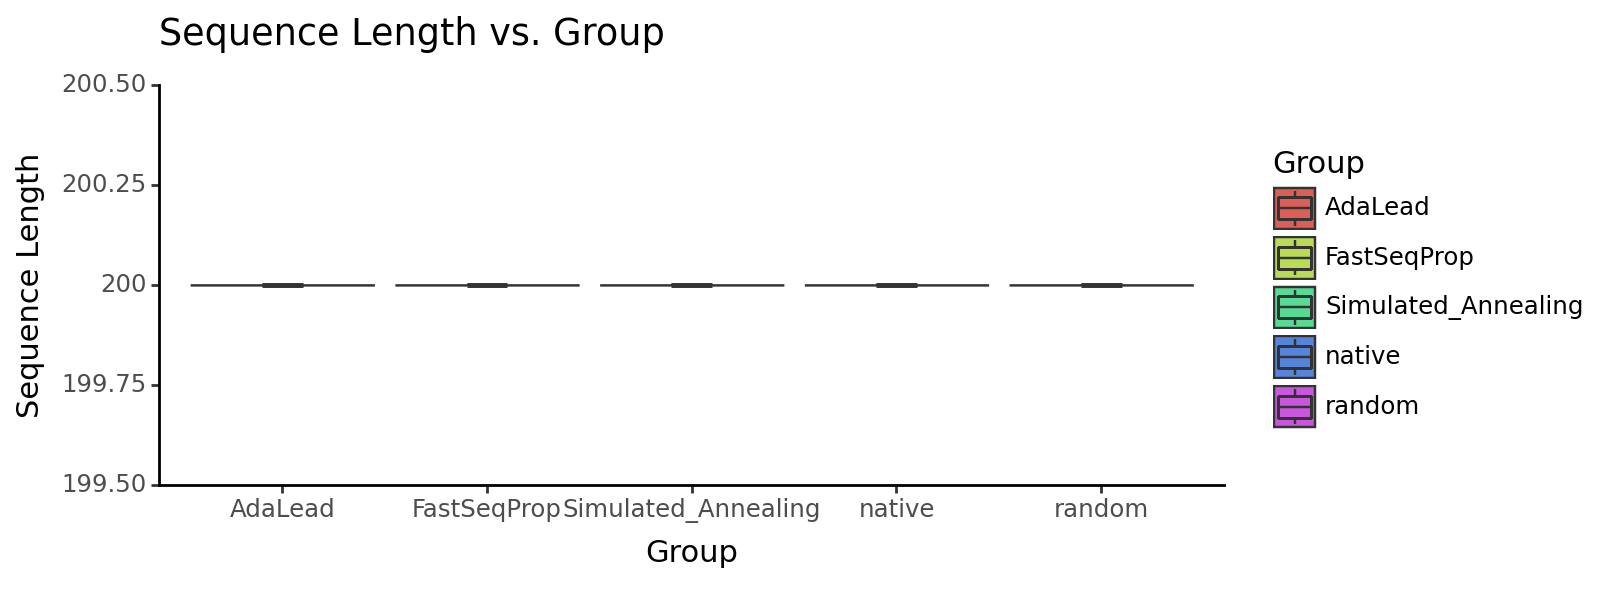

<Figure Size: (800 x 300)>

In [8]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(8, 3))

## 1.3 k-mer content

In [9]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 17.6 s, sys: 500 ms, total: 18.1 s
Wall time: 18 s


In [10]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.24987976011050114
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 2min 41s, sys: 18.4 s, total: 3min
Wall time: 42.8 s


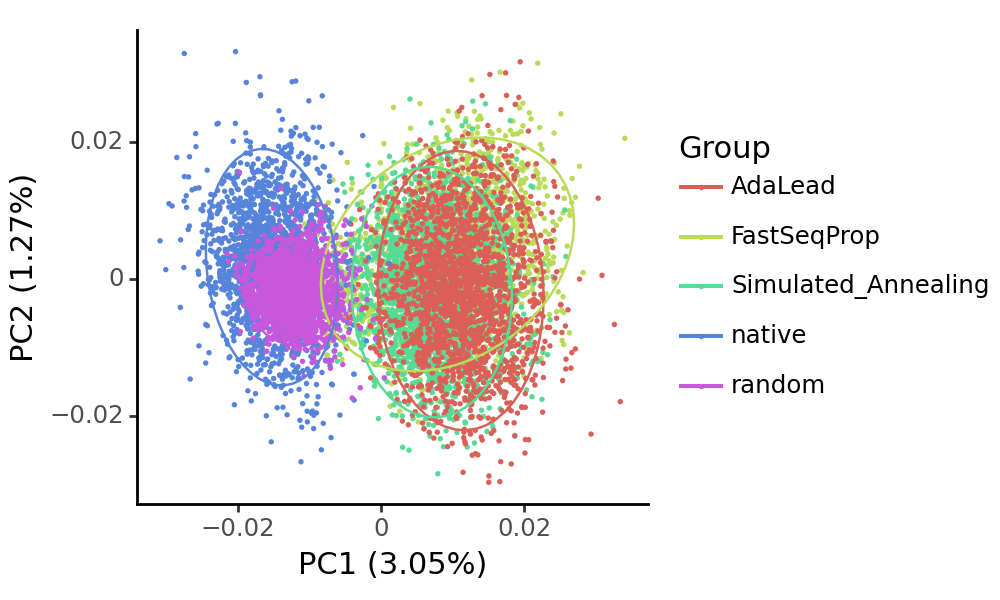

<Figure Size: (500 x 300)>

In [11]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

In [12]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: count, dtype: int64

Top Differential k-mers
                    Group  value  score       padj  log2FC
1024          FastSeqProp  GATAA  38.48   0.00e+00    1.93
0                 AdaLead  TTATC  36.80  1.76e-293    1.91
1025          FastSeqProp  TTATC  34.04  3.17e-251    1.77
2048  Simulated_Annealing  TTATC  33.95  1.33e-249    1.76
1                 AdaLead  GATAA  33.64  2.60e-245    1.74
1026          FastSeqProp  ATAAG  33.60  5.85e-245    2.09
2                 AdaLead  CTTAT  32.07  4.08e-223    2.09
3                 AdaLead  TGTCA  31.91  5.68e-221    2.14
1027          FastSeqProp  CTTAT  31.82  9.26e-220    2.08
4                 AdaLead  TGACA  30.83  1.87e-206    2.05


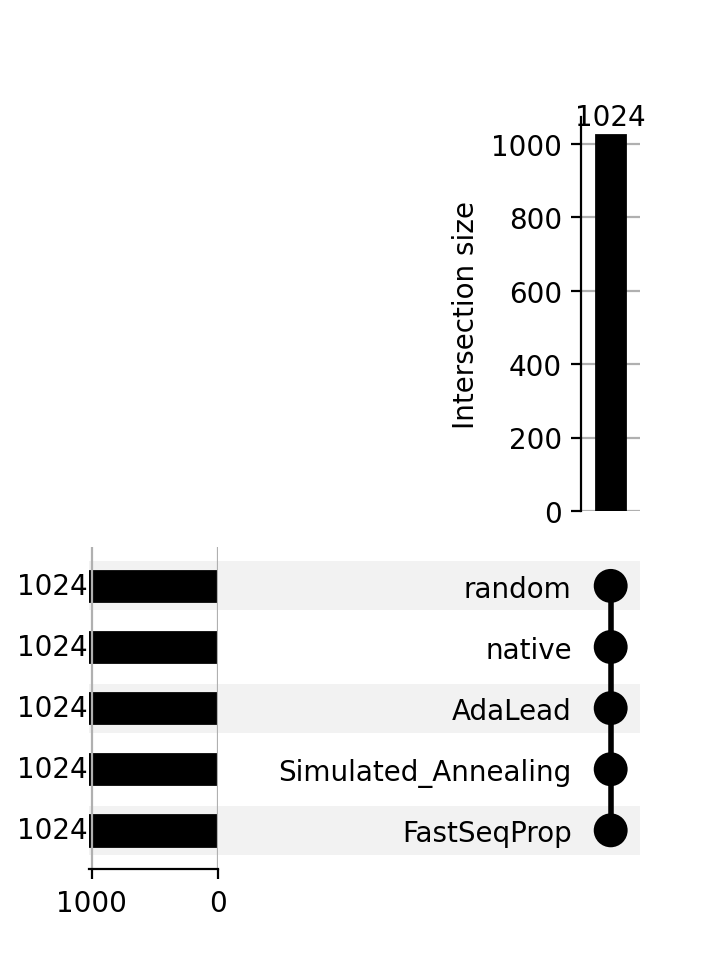

In [13]:
# kmer occurrence
polygraph.visualize.upset_plot(emb)

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.43         0.16                 0.40    0.00    0.00
FastSeqProp             0.06         0.69                 0.14    0.00    0.10
Simulated_Annealing     0.25         0.24                 0.46    0.00    0.05
native                  0.00         0.01                 0.00    0.88    0.11
random                  0.00         0.03                 0.00    0.01    0.96

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp            4.50e-03      0.88   0.0   0.0
Simulated_Annealing    3.50e-03      0.88   0.0   0.0
AdaLead                1.00e-03      0.88   0.0   0.0
random                 1.20e-02      0.88   0.0   0.0


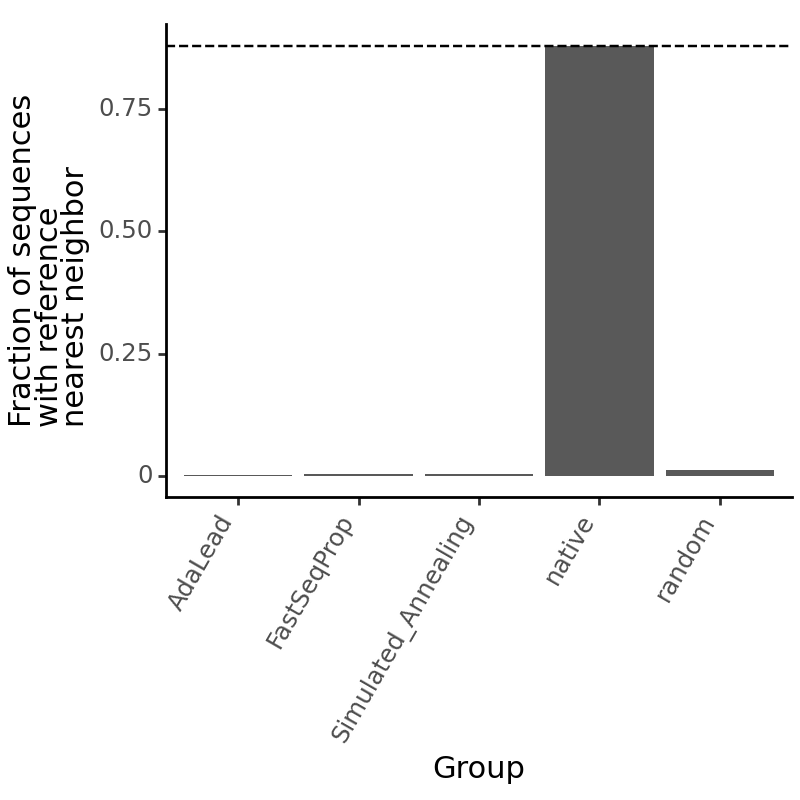

<Figure Size: (400 x 400)>

In [14]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,4))

p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.00e+00     7.52e-34             1.23e-41     0.0   
FastSeqProp          7.52e-34     1.00e+00             1.00e+00     0.0   
Simulated_Annealing  1.23e-41     1.00e+00             1.00e+00     0.0   
native               0.00e+00     0.00e+00             0.00e+00     1.0   
random               0.00e+00     0.00e+00             0.00e+00     1.0   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  1.0  
random                  1.0  }


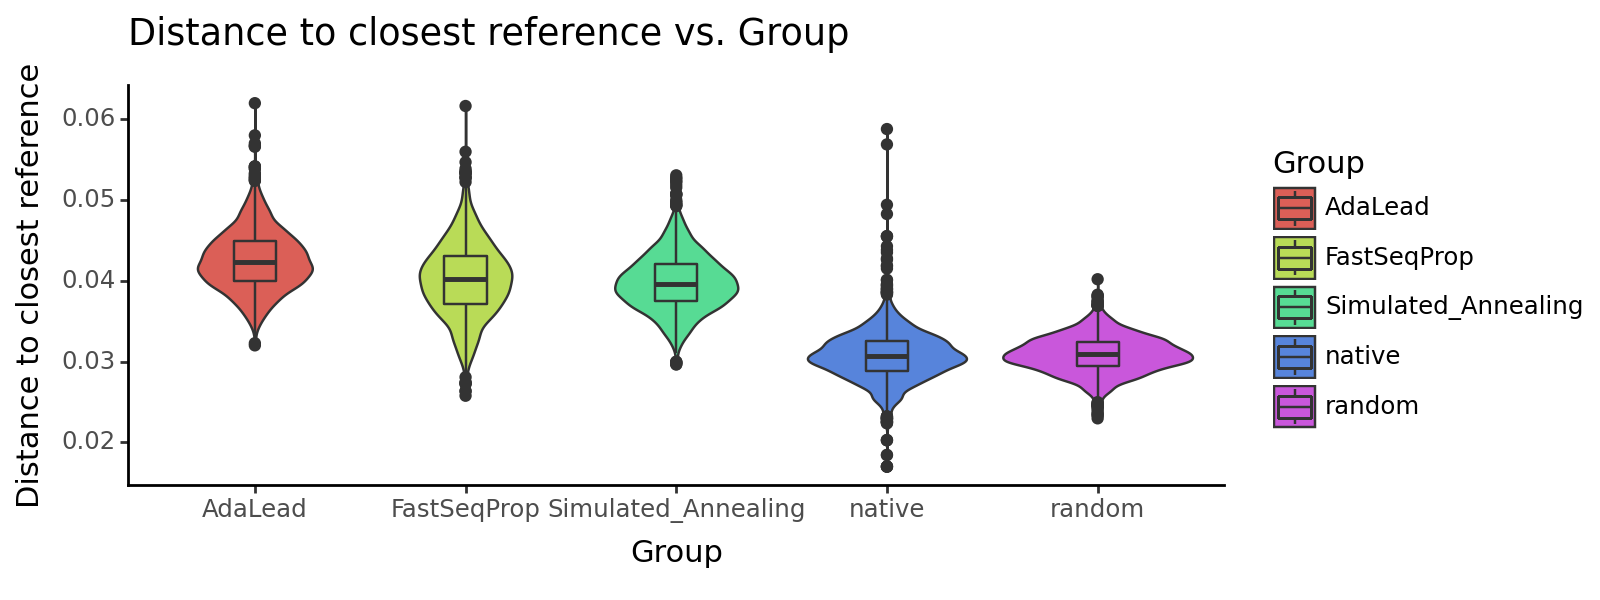

<Figure Size: (800 x 300)>

In [15]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00    9.38e-186             1.89e-46  3.06e-216   
FastSeqProp          9.38e-186     1.00e+00             9.11e-48   2.07e-01   
Simulated_Annealing   1.89e-46     9.11e-48             1.00e+00   9.64e-64   
native               3.06e-216     2.07e-01             9.64e-64   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00   0.00e+00   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  0.0  
random                  1.0  }


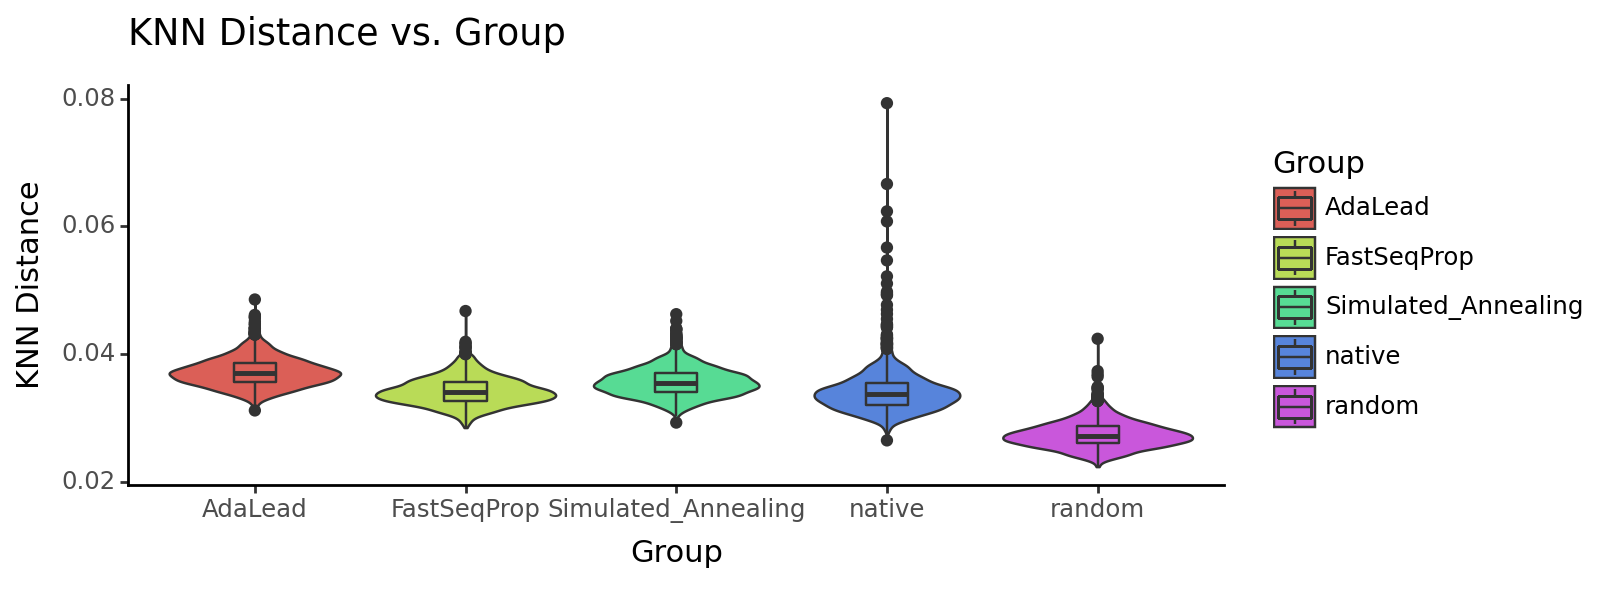

<Figure Size: (800 x 300)>

In [16]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

## 2. Motif content

In [19]:
meme_file = polygraph.input.download_jaspar("vertebrates")
meme_file

--2024-01-24 20:25:23--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179, 2001:700:2:8200::26fc
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469100 (458K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt’

     0K .......... .......... .......... .......... .......... 10%  152K 3s
    50K .......... .......... .......... .......... .......... 21%  307K 2s
   100K .......... .......... .......... .......... .......... 32%  100M 1s
   150K .......... .......... .......... .......... .......... 43%  308K 1s
   200K .......... .......... .......... .......... .......... 54%  160M 1s
   250K .......... .......... .......... .......... .......... 65%  208M 0s
   300K .......... ........

'/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt'

In [17]:
%%time 
sites = polygraph.motifs.scan(seqs, '/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt')

Read 879 motifs from file.
CPU times: user 3min 27s, sys: 457 ms, total: 3min 27s
Wall time: 3min 27s


In [18]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

MotifID,ALX3,ARGFX,ARNT2,ARNT::HIF1A,ASCL1
SeqID,,,,,
seq_0,0.0,0.0,5.00e-03,5.00e-03,0.04
seq_1,0.0,0.0,0.00e+00,0.00e+00,0.01
seq_10,0.0,0.0,0.00e+00,5.00e-03,0.05
seq_100,0.0,0.0,0.00e+00,0.00e+00,0.03
seq_1000,0.0,0.0,0.00e+00,5.00e-03,0.09


In [19]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.18 0.07 0.03 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.632727208667664
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 4min 52s, sys: 13.5 s, total: 5min 5s
Wall time: 2min 10s


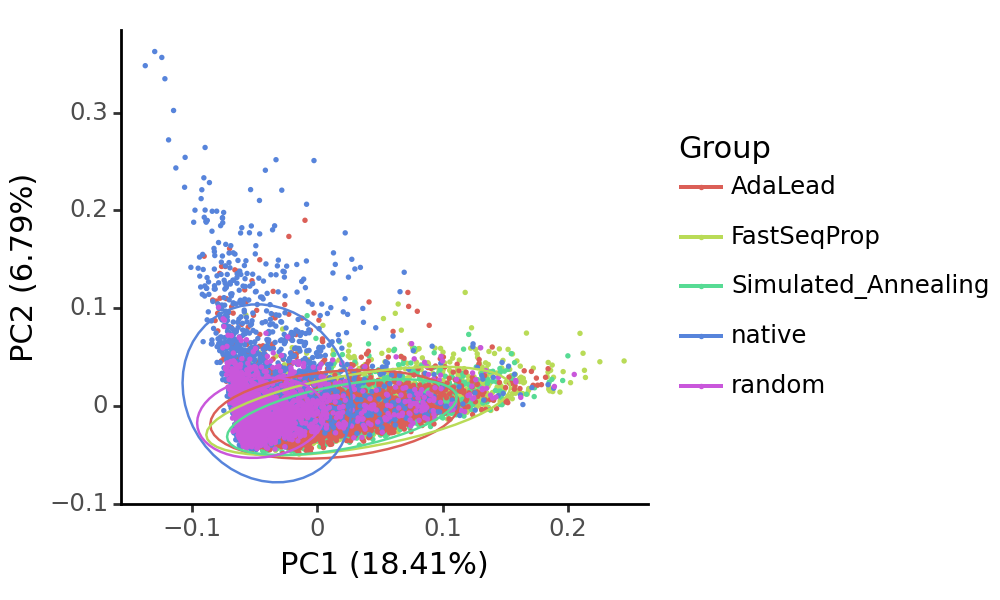

<Figure Size: (500 x 300)>

In [20]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

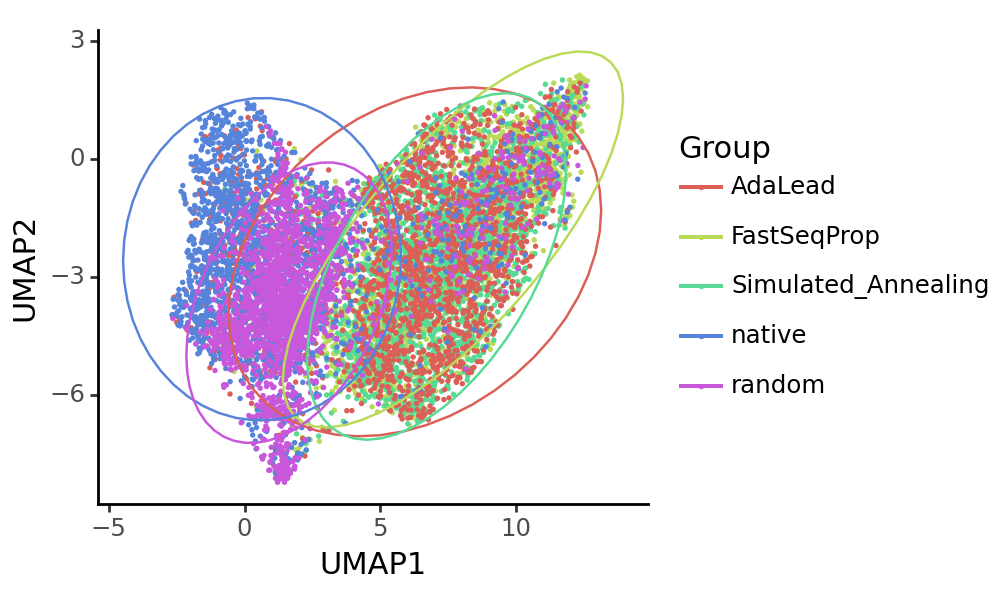

<Figure Size: (500 x 300)>

In [25]:
polygraph.visualize.umap_plot(emb) + p9.theme(figure_size=(5, 3))

In [21]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential motifs compared to reference
Group
Simulated_Annealing    619
random                 599
FastSeqProp            587
AdaLead                582
Name: count, dtype: int64

Top Differential motifs
                    Group  value  score       padj  log2FC
0                 AdaLead  GATA5  39.73   0.00e+00    1.62
830           FastSeqProp  TRPS1  38.23   0.00e+00    1.41
1656  Simulated_Annealing  GATA5  43.71   0.00e+00    1.68
1657  Simulated_Annealing  GATA2  42.01   0.00e+00    1.50
1658  Simulated_Annealing  TRPS1  38.42   0.00e+00    1.34
1659  Simulated_Annealing  GATA6  37.75   0.00e+00    1.32
829           FastSeqProp  GATA2  40.88   0.00e+00    1.52
828           FastSeqProp  GATA5  42.74   0.00e+00    1.68
1                 AdaLead  GATA2  38.89   0.00e+00    1.47
831           FastSeqProp  GATA6  37.64  1.14e-307    1.40


Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.34         0.19                 0.29    0.09    0.09
FastSeqProp             0.22         0.34                 0.28    0.06    0.10
Simulated_Annealing     0.28         0.25                 0.38    0.03    0.05
native                  0.12         0.08                 0.06    0.46    0.30
random                  0.03         0.06                 0.05    0.11    0.75

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop       pval       padj
Group                                                          
FastSeqProp                0.06      0.46  1.90e-198  3.79e-198
Simulated_Annealing        0.03      0.46  1.73e-239  6.92e-239
AdaLead                    0.09      0.46  2.14e-157  2.85e-157
random                  

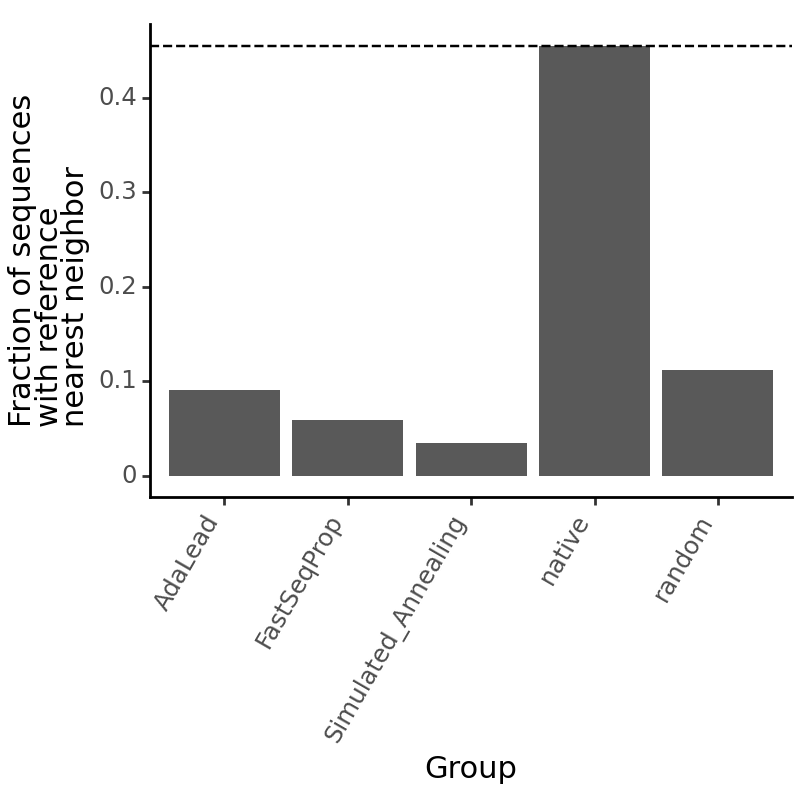

<Figure Size: (400 x 400)>

In [22]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,4))

p-values for distance to closest reference
{'Kruskal': 5.440438898933723e-195, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     6.26e-18             1.01e-01   3.10e-01   
FastSeqProp           6.26e-18     1.00e+00             2.68e-09   1.69e-10   
Simulated_Annealing   1.01e-01     2.68e-09             1.00e+00   1.00e+00   
native                3.10e-01     1.69e-10             1.00e+00   1.00e+00   
random               2.32e-148     7.25e-65            1.10e-120  5.91e-125   

                        random  
AdaLead              2.32e-148  
FastSeqProp           7.25e-65  
Simulated_Annealing  1.10e-120  
native               5.91e-125  
random                1.00e+00  }


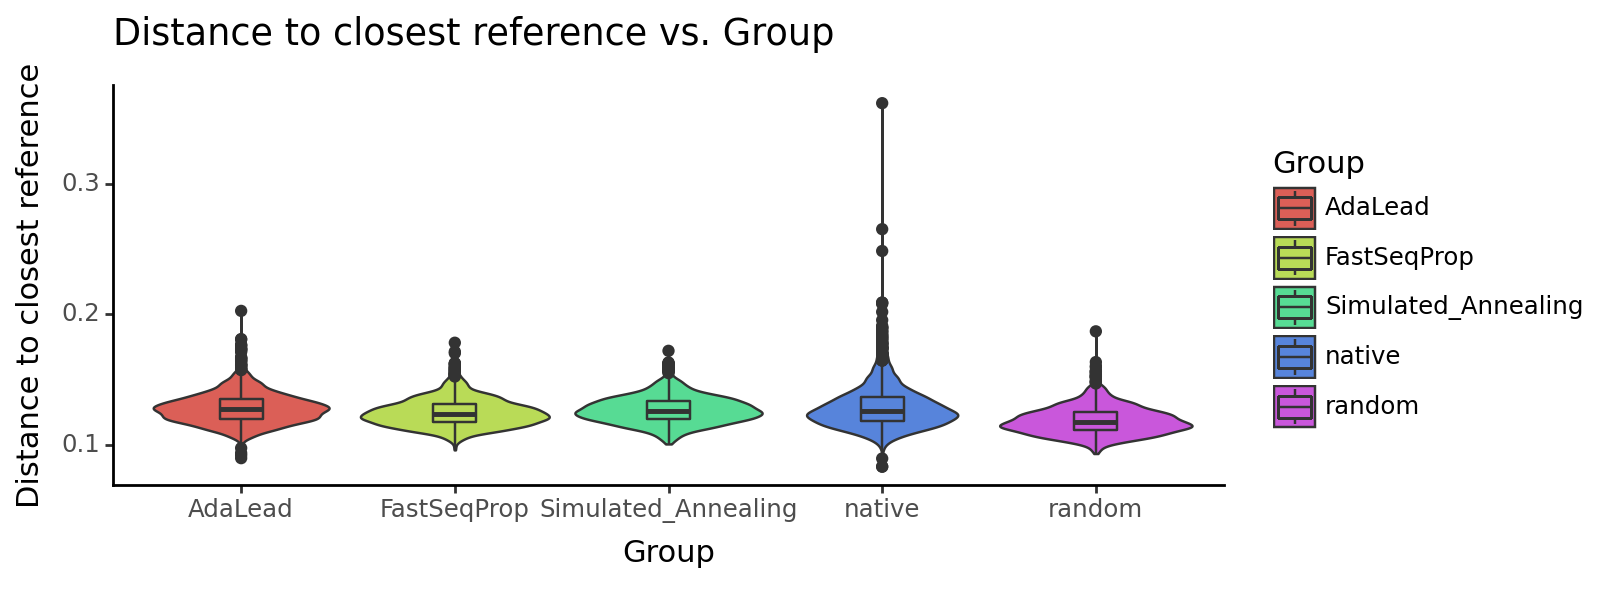

<Figure Size: (800 x 300)>

In [23]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

p-values for KNN diversity
{'Kruskal': 1.3157197048027366e-294, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     4.90e-15             1.41e-11   9.98e-33   
FastSeqProp           4.90e-15     1.00e+00             1.00e+00   6.71e-90   
Simulated_Annealing   1.41e-11     1.00e+00             1.00e+00   4.72e-81   
native                9.98e-33     6.71e-90             4.72e-81   1.00e+00   
random               6.87e-124     3.04e-54             1.63e-61  7.66e-281   

                        random  
AdaLead              6.87e-124  
FastSeqProp           3.04e-54  
Simulated_Annealing   1.63e-61  
native               7.66e-281  
random                1.00e+00  }


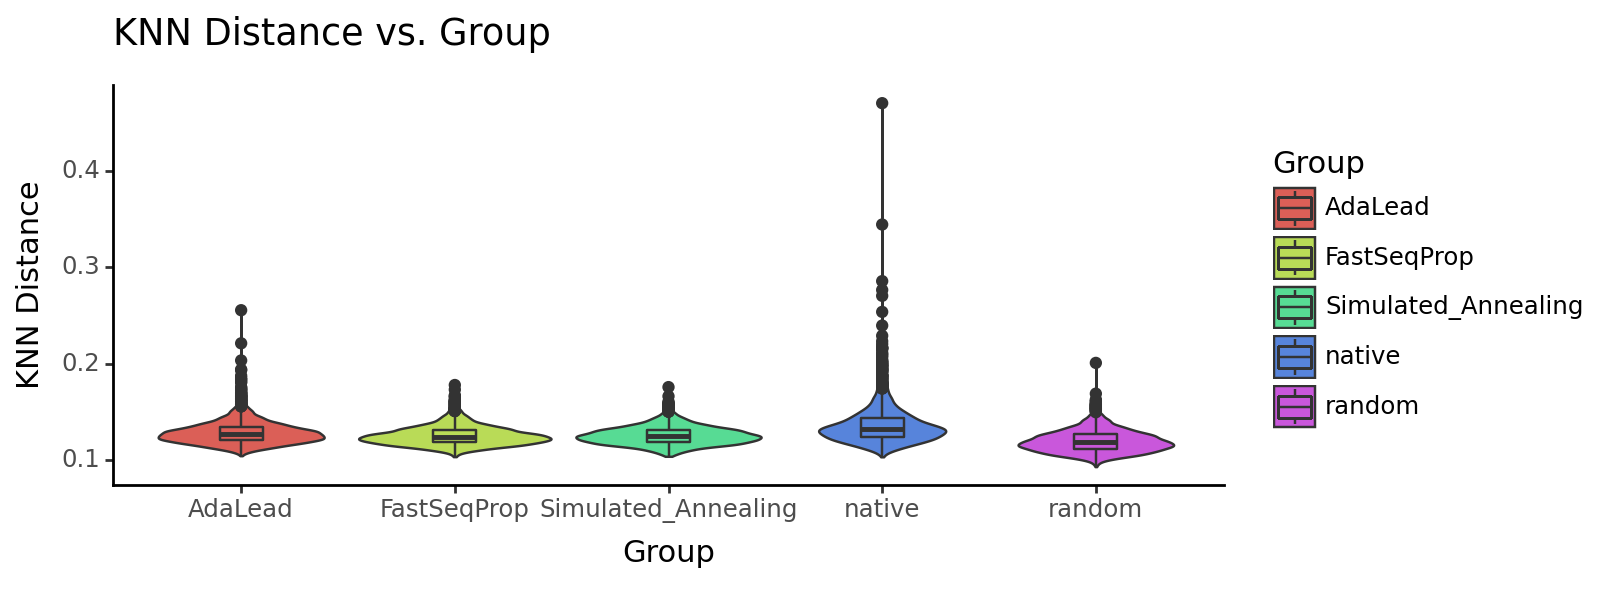

<Figure Size: (800 x 300)>

In [24]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

## 2.2 Motif combinations

We will identify co-occurring combinations of motifs using the count matrix. This can take a long time, so for speed we use only the first 100 motifs from JASPAR.

In [33]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(counts.iloc[:, :100], seqs, reference_group='native', min_group_freq=400)

Listing motif combinations
Making count matrix
Filtering
Selected 3750 combinations
Significance testing
CPU times: user 2min 10s, sys: 254 ms, total: 2min 10s
Wall time: 2min 10s


In [34]:
motif_combinations.sort_values('padj').head(10)

,Group,group_prop,ref_prop,pval,padj,combination
170,AdaLead,0.57,0.04,0.0,0.0,"(BHLHE22, E2F2)"
113,Simulated_Annealing,0.62,0.03,0.0,0.0,"(E2F7, E2F2)"
66,AdaLead,0.64,0.06,0.0,0.0,"(E2F4, E2F1)"
110,AdaLead,0.58,0.04,0.0,0.0,"(E2F4, E2F7)"
109,Simulated_Annealing,0.62,0.04,0.0,0.0,"(E2F4, E2F7)"
65,Simulated_Annealing,0.68,0.06,0.0,0.0,"(E2F4, E2F1)"
114,AdaLead,0.58,0.03,0.0,0.0,"(E2F7, E2F2)"
169,Simulated_Annealing,0.57,0.04,0.0,0.0,"(BHLHE22, E2F2)"
61,Simulated_Annealing,0.68,0.05,0.0,0.0,"(E2F4, E2F8)"
54,AdaLead,0.64,0.05,0.0,0.0,"(E2F8, E2F2)"


In [39]:
# Are there any significant motif combinations where neither individual motif
# is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .05]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [40]:
sig_combs

,Group,group_prop,ref_prop,pval,padj,combination


## 2.3 Motif positions

In [41]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

,Group,value,score,padj,log2FC
0,AdaLead,GATA5,39.73,0.0,1.62
830,FastSeqProp,TRPS1,38.23,0.0,1.41
1656,Simulated_Annealing,GATA5,43.71,0.0,1.68
1657,Simulated_Annealing,GATA2,42.01,0.0,1.50
1658,Simulated_Annealing,TRPS1,38.42,0.0,1.34


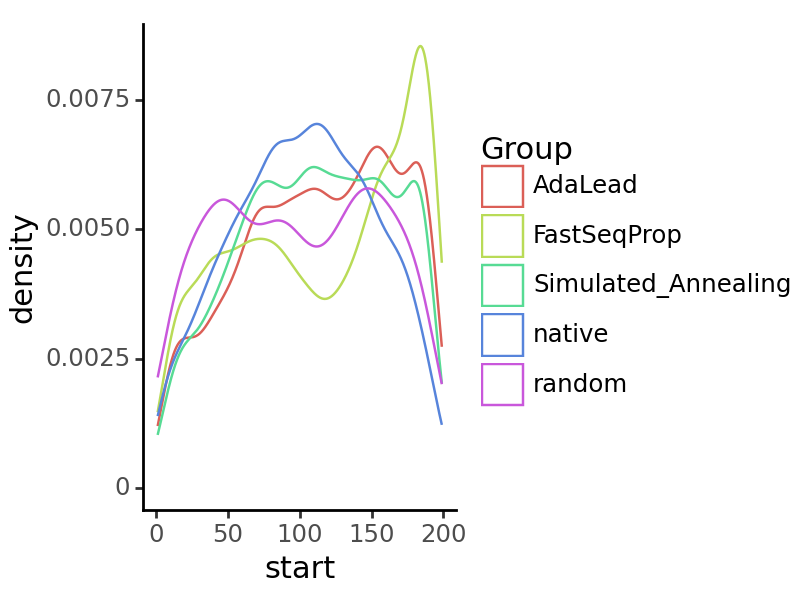

<Figure Size: (400 x 300)>

In [43]:
polygraph.visualize.densityplot(sites[sites.MotifID=='GATA2'], value_col='start') + p9.theme(figure_size=(4, 3))

In [44]:
polygraph.stats.kruskal_dunn(sites[sites.MotifID=='GATA2'], val_col='start')

{'Kruskal': 1.0023563364372272e-27,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.00e+00     2.79e-01             8.34e-03  2.43e-15   
 FastSeqProp          2.79e-01     1.00e+00             5.08e-07  3.34e-21   
 Simulated_Annealing  8.34e-03     5.08e-07             1.00e+00  1.01e-07   
 native               2.43e-15     3.34e-21             1.01e-07  1.00e+00   
 random               1.41e-07     4.27e-10             2.78e-04  1.00e+00   
 
                        random  
 AdaLead              1.41e-07  
 FastSeqProp          4.27e-10  
 Simulated_Annealing  2.78e-04  
 native               1.00e+00  
 random               1.00e+00  }

## 2.4 NMF

In [45]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

CPU times: user 2min 5s, sys: 4.69 s, total: 2min 9s
Wall time: 1.29 s


In [46]:
p.sort_values('padj', ascending=False).head()

,group,pval,padj,factor
3,random,3.11e-01,3.11e-01,factor_4
0,FastSeqProp,1.45e-01,1.49e-01,factor_9
3,random,2.04e-02,2.15e-02,factor_7
1,Simulated_Annealing,5.79e-05,6.26e-05,factor_9
3,random,1.36e-05,1.52e-05,factor_3


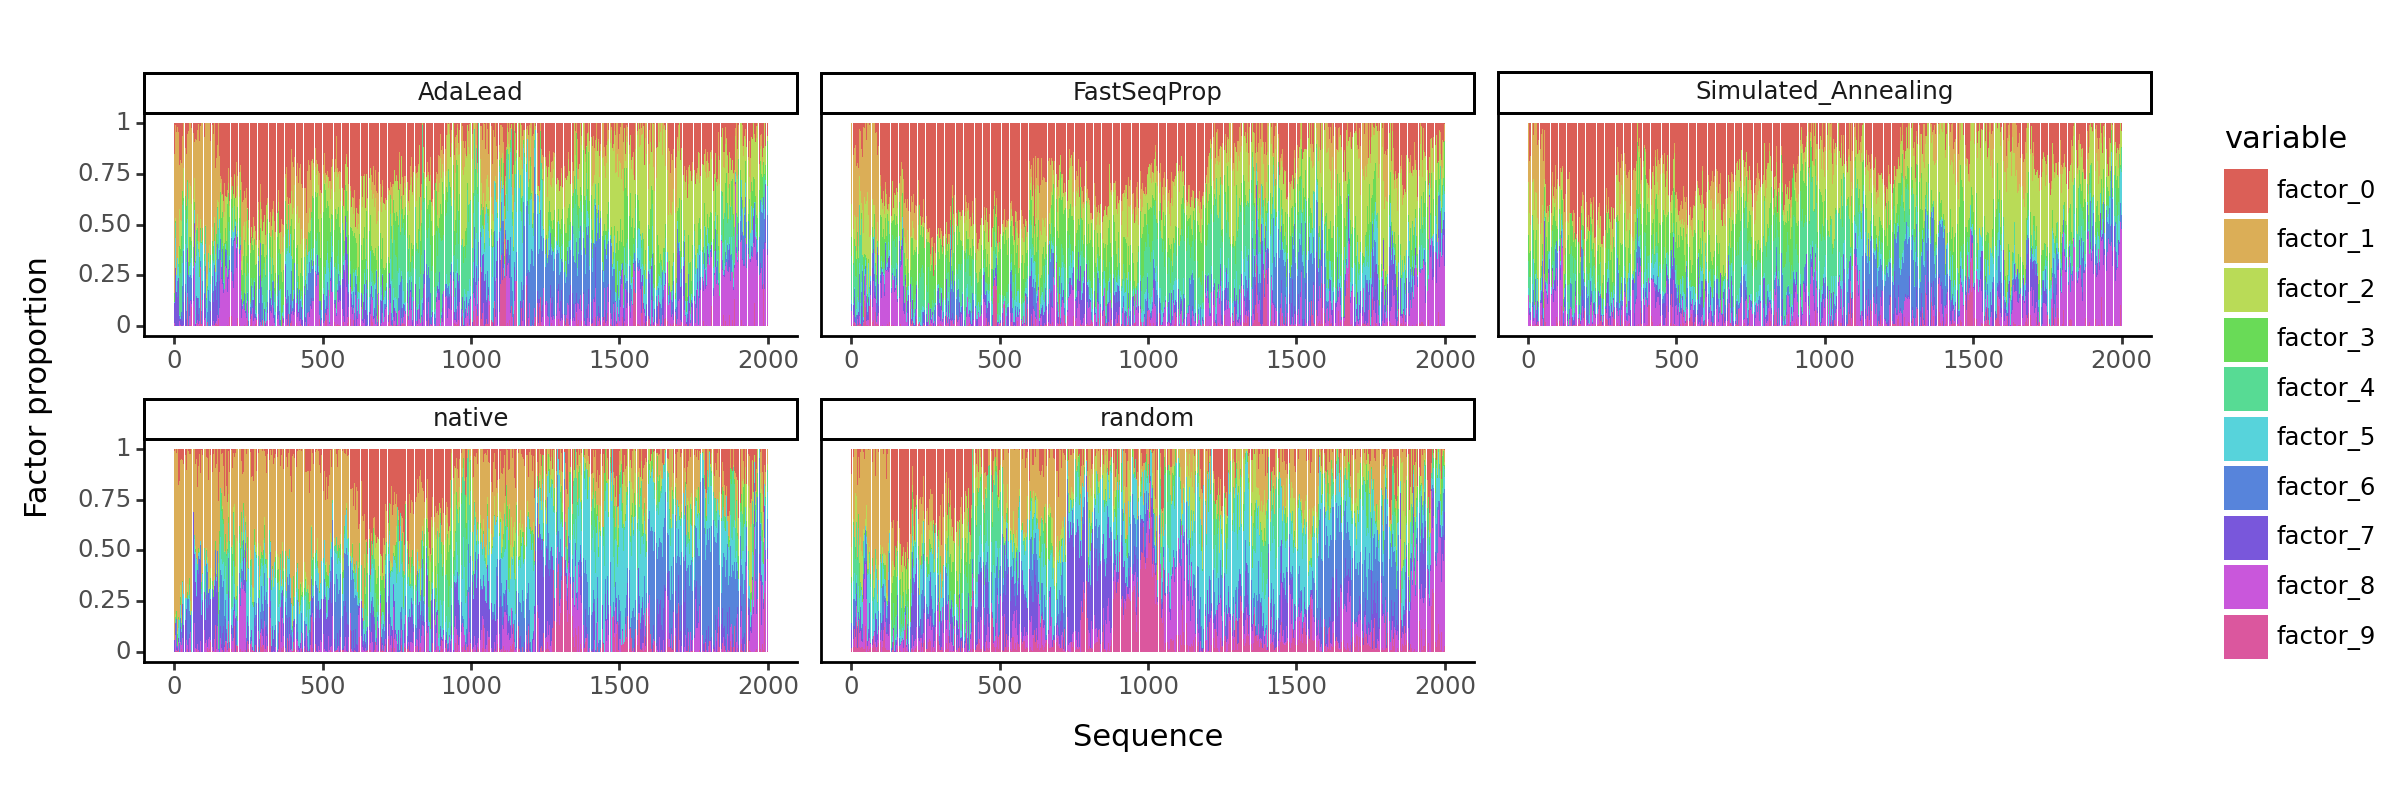

<Figure Size: (1200 x 400)>

In [47]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

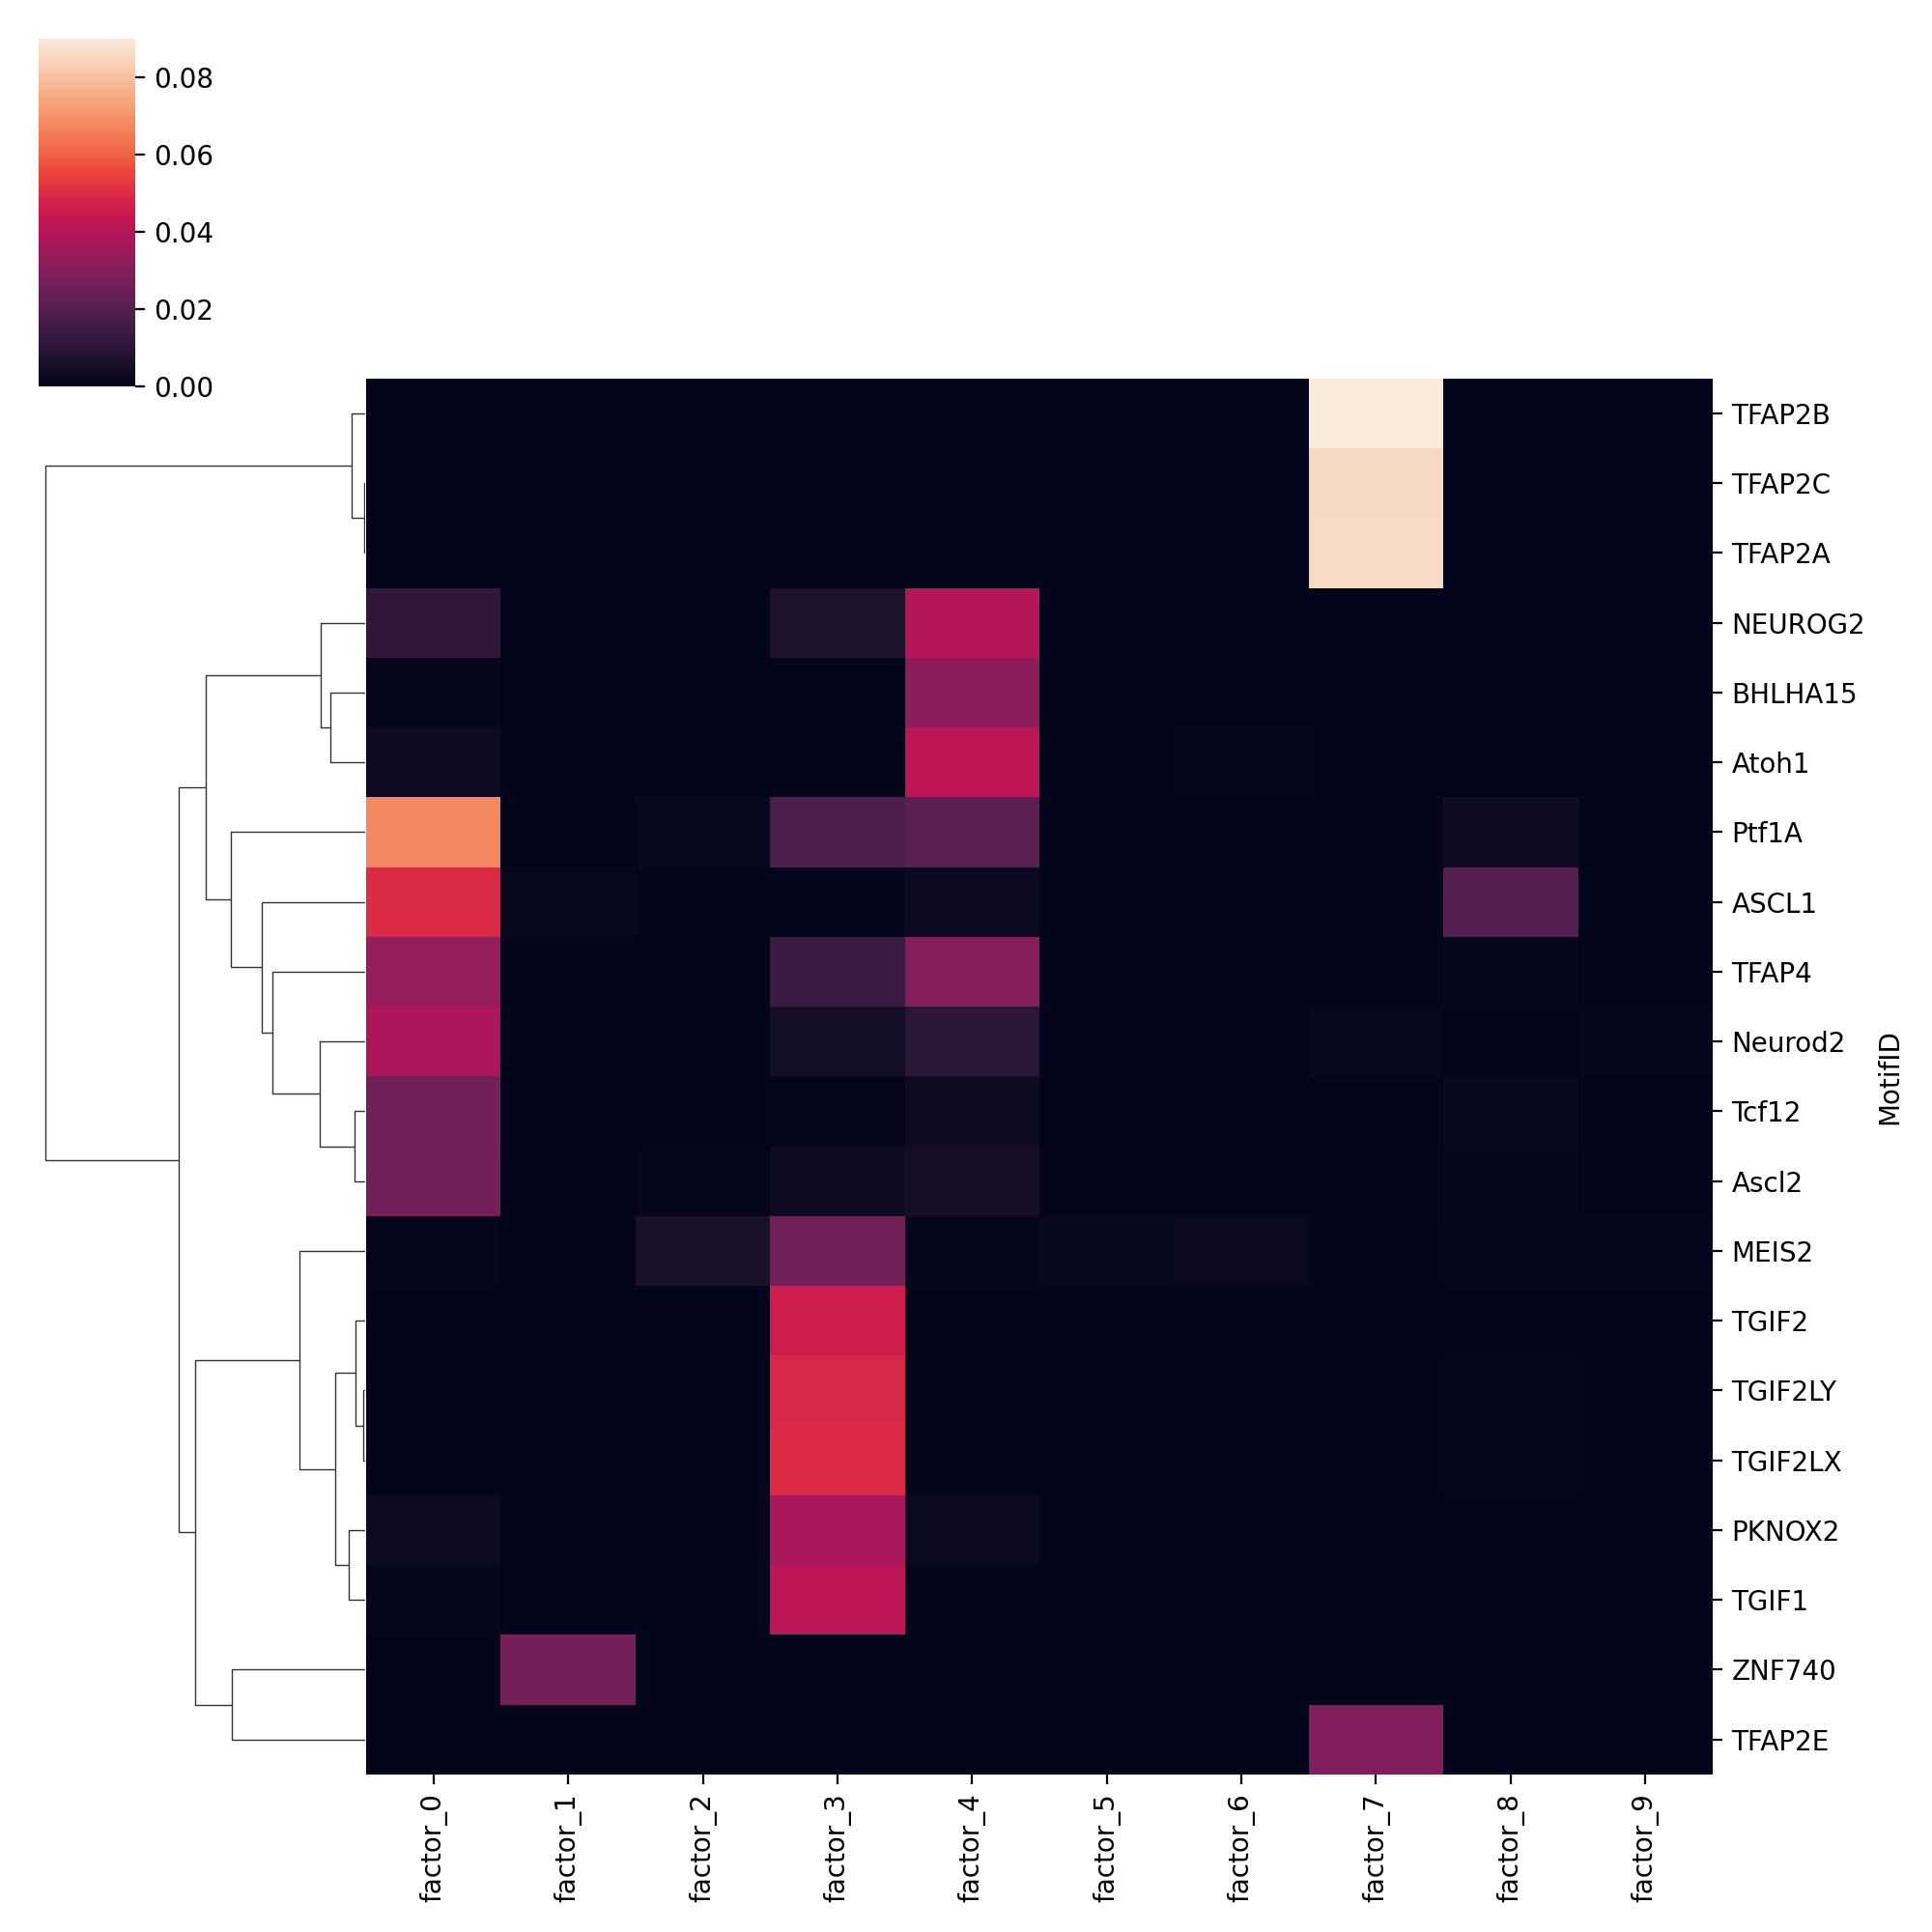

In [48]:
polygraph.visualize.plot_factors_nmf(H, n_features=20)

# 3. Model predictions

### Load model trained on catlas data

In [49]:
!wget https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth

--2024-01-24 20:43:38--  https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288449775 (275M) [application/octet-stream]
Saving to: ‘catlas-enformer-release-model_2.pth’

catlas-enformer-rel 100%[===================>] 275.09M  18.1MB/s    in 17s     

2024-01-24 20:43:56 (16.2 MB/s) - ‘catlas-enformer-release-model_2.pth’ saved [288449775/288449775]



In [50]:
import torch
model = torch.load('catlas-enformer-release-model_2.pth')

### Get model predictions

In [51]:
preds = polygraph.models.predict(model, seqs, batch_size=512)
preds.shape

Padding all sequences to length 200


(10000, 203)

### Model embeddings

In [52]:
embeddings = polygraph.models.sequential_embed(seqs.Sequence.tolist(), model, drop_last_layers=4, swapaxes=True)
embeddings.shape

(10000, 1536)

In [53]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.74 0.07 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9680153
UMAP
Differential feature abundance


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value 

1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 3min 9s, sys: 10.7 s, total: 3min 20s
Wall time: 53.5 s


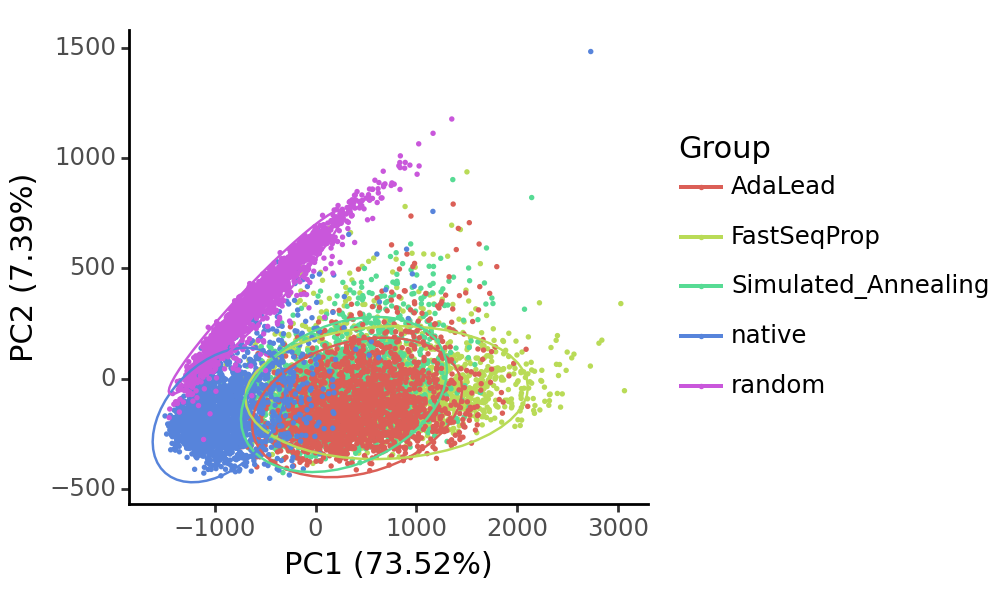

<Figure Size: (500 x 300)>

In [54]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.57         0.10                 0.32    0.00    0.00
FastSeqProp             0.12         0.65                 0.22    0.00    0.01
Simulated_Annealing     0.33         0.18                 0.49    0.00    0.00
native                  0.00         0.01                 0.00    0.94    0.04
random                  0.00         0.01                 0.00    0.01    0.98
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp            1.00e-03      0.94   0.0   0.0
Simulated_Annealing    1.00e-03      0.94   0.0   0.0
AdaLead                0.00e+00      0.94   0.0   0.0
random                 1.15e-02      0.94   0.0   0.0


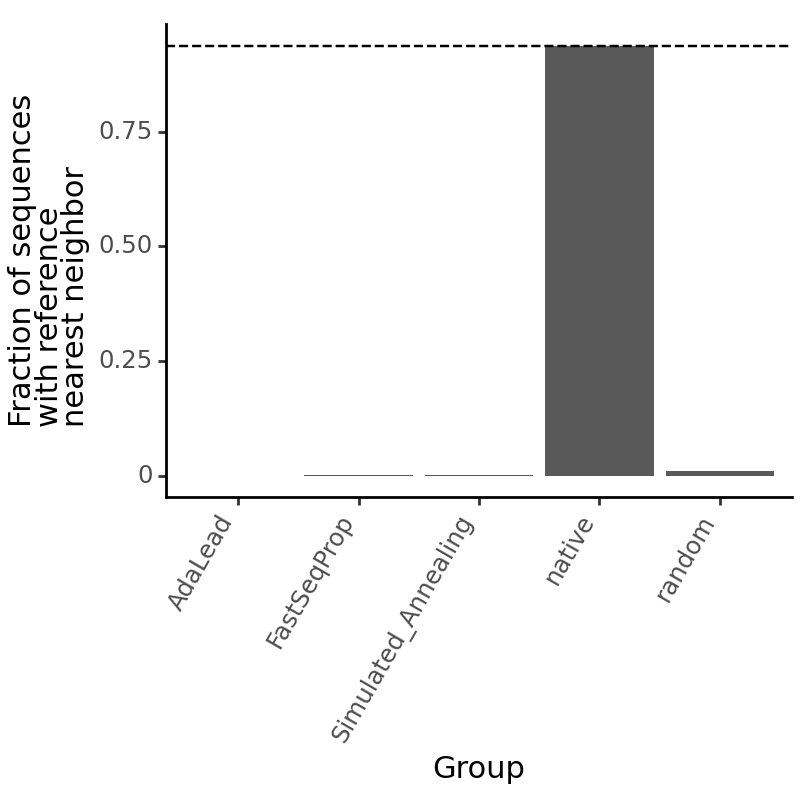

<Figure Size: (400 x 400)>

In [55]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,4))

{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
AdaLead              1.00e+00     1.79e-08             1.23e-09  0.00e+00   
FastSeqProp          1.79e-08     1.00e+00             1.37e-34  0.00e+00   
Simulated_Annealing  1.23e-09     1.37e-34             1.00e+00  0.00e+00   
native               0.00e+00     0.00e+00             0.00e+00  1.00e+00   
random               0.00e+00     0.00e+00            1.08e-241  1.17e-55   

                        random  
AdaLead               0.00e+00  
FastSeqProp           0.00e+00  
Simulated_Annealing  1.08e-241  
native                1.17e-55  
random                1.00e+00  }


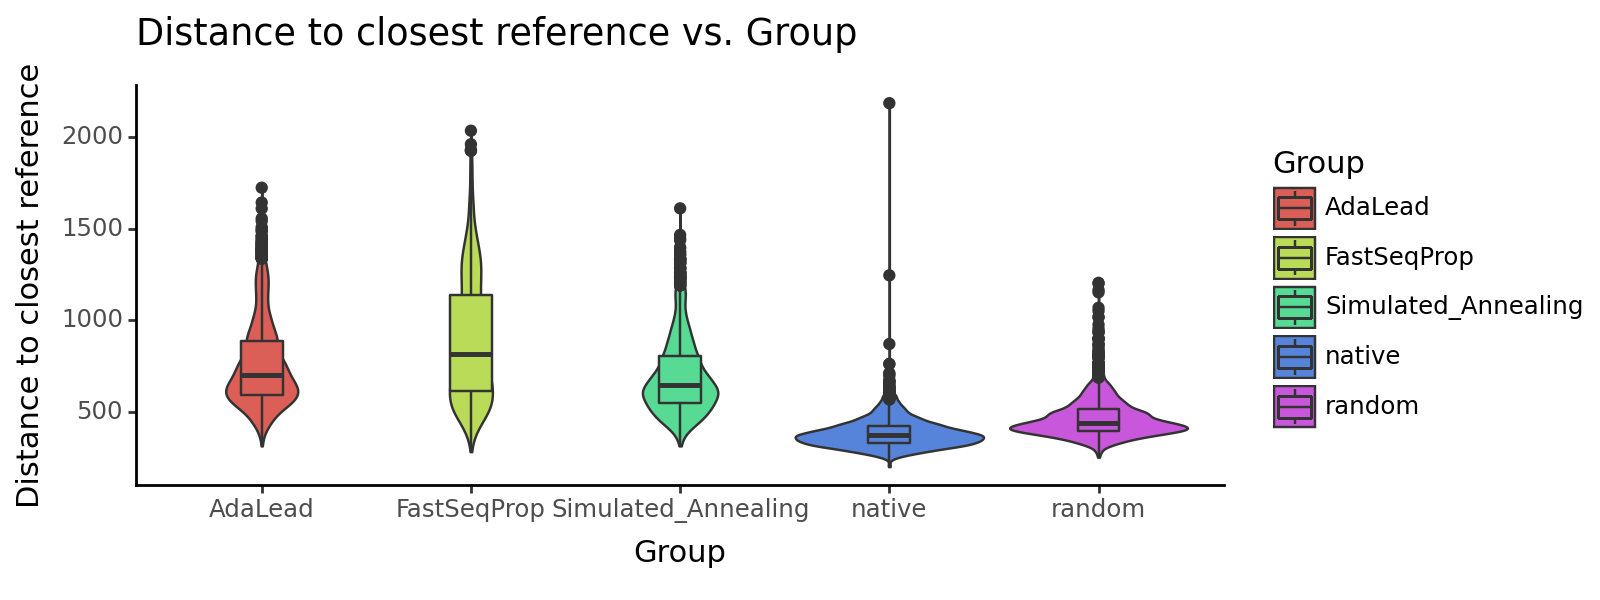

<Figure Size: (800 x 300)>

In [56]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing    native  \
AdaLead               1.00e+00     1.76e-11             4.56e-01  2.32e-25   
FastSeqProp           1.76e-11     1.00e+00             1.40e-18  3.56e-03   
Simulated_Annealing   4.56e-01     1.40e-18             1.00e+00  1.58e-35   
native                2.32e-25     3.56e-03             1.58e-35  1.00e+00   
random               1.97e-274     0.00e+00            1.75e-244  0.00e+00   

                        random  
AdaLead              1.97e-274  
FastSeqProp           0.00e+00  
Simulated_Annealing  1.75e-244  
native                0.00e+00  
random                1.00e+00  }


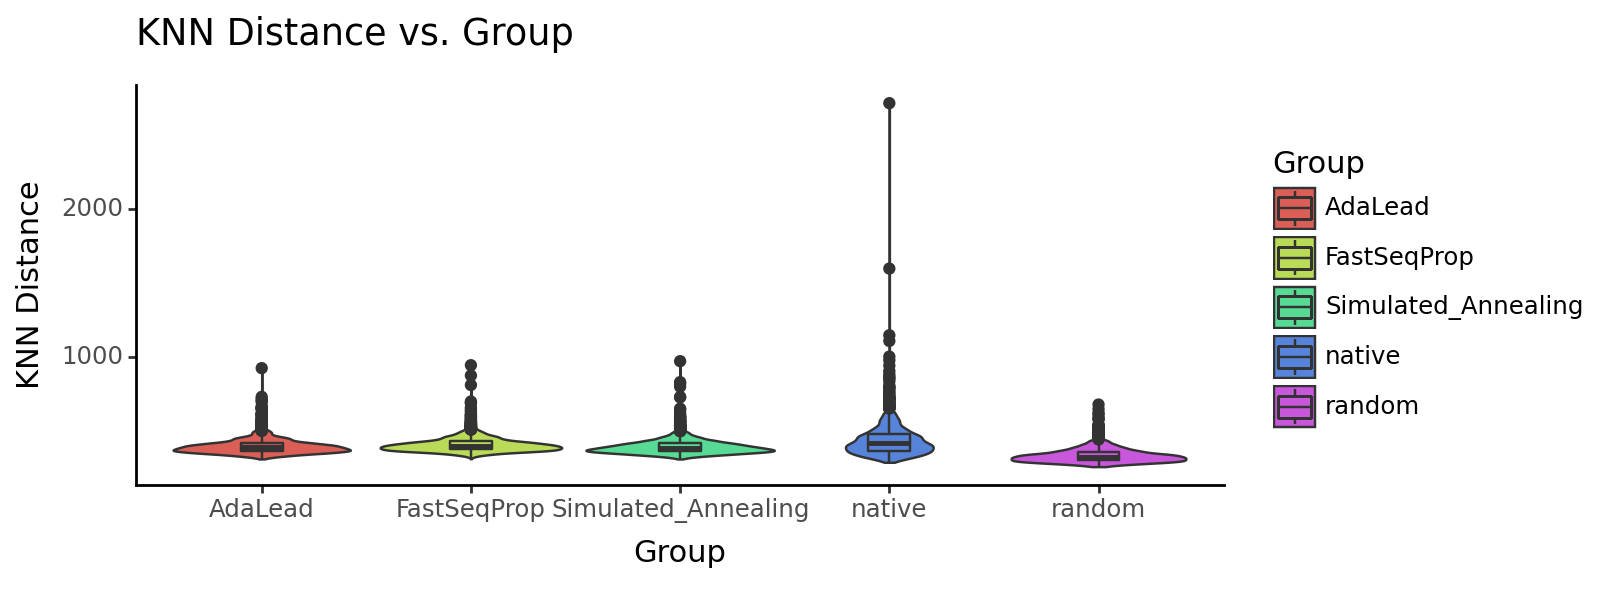

<Figure Size: (800 x 300)>

In [57]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

# 4. Language model likelihood calculation

In [58]:
# Substitute '/hyena-dna' with the path to your cloned hyena-dna repository
# See https://github.com/HazyResearch/hyena-dna for instructions to clone and install hyenadna
model = polygraph.likelihood.load_hyenadna(hyena_path='/hyena-dna')

--2024-01-24 20:45:59--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 108.138.246.79, 108.138.246.85, 108.138.246.67, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535 [text/plain]
Saving to: ‘./config.json’

     0K                                                       100%  157M=0s

2024-01-24 20:45:59 (157 MB/s) - ‘./config.json’ saved [535/535]

--2024-01-24 20:45:59--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/weights.ckpt
Resolving huggingface.co (huggingface.co)... 108.138.246.71, 108.138.246.85, 108.138.246.79, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/23/bd/23bd011121e3699e6bfa5aa57274ac119b996f4c129b31145d6fffeaa6229b55/33558e085d0545

Loading config
Building model
Loading weights


In [60]:
log_likelihood = polygraph.likelihood.compute_likelihood(
    seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

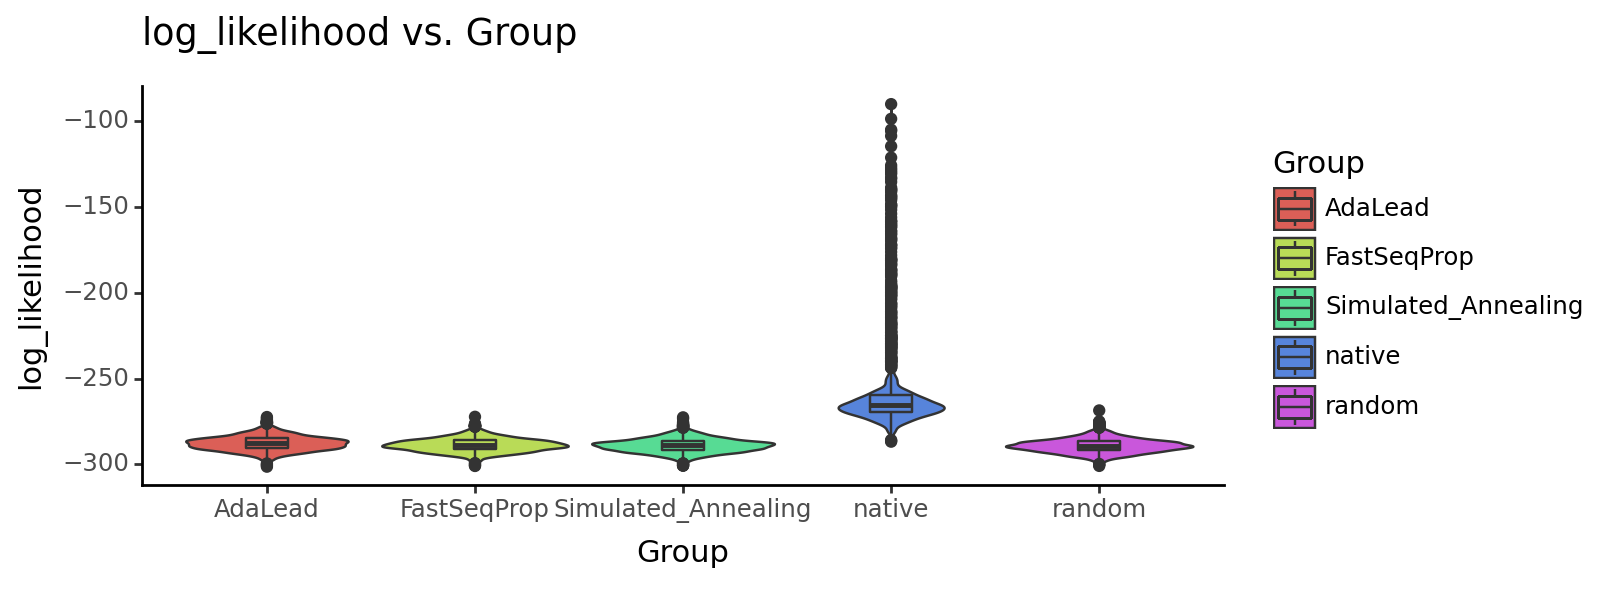

<Figure Size: (800 x 300)>

In [61]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood") + p9.theme(figure_size=(8, 3))